In [1]:
# Copyright 2019 Steven Mattis and Troy Butler
import numpy as np
import matplotlib.pyplot as plt
import dynamical_systems as ds
from scipy.stats import gaussian_kde as GKDE
from luq import *

Model is for harmonic motion
$$y''(t) + 2cy'(t) + \omega_0^2 x = f(t)$$
with damping constant
$$c \in [0.1,1]$$
and natural frequency
$$\omega_0\in[0.5,2]$$
and forcing term initially taken to be zero.

Note that with the ranges of $c$ and $\omega_0$ above, it is possible for the system to either be under-, over-, or critically damped (and since $c\geq 0.1$ it is never undamped, which is almost always physical nonsense). 

The roots to the characteristic equation are given by
$$ r_1 = -c\pm \sqrt{c^2-\omega_0^2}$$.

When the system is under-damped, the solution is given by
$$ y(t) = e^{-ct}[C_1\cos(\omega t) + C_2\sin(\omega t)], \ \omega=\sqrt{\omega_0^2-c^2}. $$


When the system is over-damped, the solution is given by 
$$ y(t) = C_1 e^{r_1t}+C_2 e^{r_2t}. $$

And, finally, when the system is critically damped, the solution is given by
$$ y(t) = C_1e^{-ct} + C_2 te^{-ct}. $$

However, we never expect the system to be critically damped in practice since this is "too fine-tuned" of a scenario. 

The constants $C_1$ and $C_2$ are determined by the initial conditions, which we assume to be given by
$$ y(0)=a, y'(0) = b $$
where 
$$ a\in[1,2] $$ 
and 
$$ b\in[-1,0] $$. 

In the under-damped case, 
$$ C_1 = a, \ \text{and } \ C_2 = \frac{b+ca}{\omega}. $$

In the over-damped case, 
$$ C_1 = \frac{b-ar_2}{r_1-r_2}, \ \text{and } \ C_2 = \frac{b-r_1a}{r_2-r_1} $$

A ***true*** distribution of $c, \omega_0, a$, and $b$ are defined by (non-uniform)
Beta distributions and used to generate a set of time series data.

An ***initial*** uniform distribution is assumed and updated by the true time series data.

In [2]:
# Uniformly sample the parameter samples to form a "prediction" or "test" set
num_samples = int(1E3)

params = np.random.uniform(size=(num_samples, 2))
ics = np.random.uniform(size=(num_samples, 2))

param_range = np.array([[0.1, 1.0],  # c
                        [0.5, 2.0]])  # omega_0
ic_range = np.array([[1.0, 2.0],  #a
                     [-1.0, 0.0]])  #b
params = param_range[:, 0] + (param_range[:, 1] - param_range[:, 0]) * params
ics = ic_range[:, 0] + (ic_range[:, 1] - ic_range[:, 0]) * ics
param_labels = [r'$c$', r'$\omega_0$']
ic_labels = [r'$a$', r'$b$']

# Construct the predicted time series data

num_time_preds = int(50)  # number of predictions (uniformly space) between [time_start,time_end]
time_start = 0.5
time_end = 3.5
times = np.linspace(time_start, time_end, num_time_preds)

phys = ds.HarmonicOscillator()
predicted_time_series = phys.solve(ics=ics, params=params, t_eval=times)


# Simulate an observed Beta distribution of time series data

num_obs = int(1E3)

true_a = 2
true_b = 2

params_obs = np.random.beta(size=(num_obs, 2), a=true_a, b=true_b)
ics_obs = np.random.beta(size=(num_obs, 2), a=true_a, b=true_b)
params_obs = param_range[:, 0] + (param_range[:, 1] - param_range[:, 0]) * params_obs
ics_obs = ic_range[:, 0] + (ic_range[:, 1] - ic_range[:, 0]) * ics_obs

observed_time_series = phys.solve(ics=ics_obs, params=params_obs, t_eval=times)

# Add noise if desired
with_noise = False
noise_stdev = 0.05

if with_noise:
    observed_time_series += noise_stdev * np.random.randn(num_obs)

In [3]:
# Use LUQ to learn dynamics and QoIs
learn = LUQ(predicted_time_series, observed_time_series, times)

# time array indices over which to use
time_start_idx = 0
time_end_idx = 49

# Clean data with piecewise linear splines
learn.clean_data(time_start_idx=time_start_idx, time_end_idx=time_end_idx,
                     num_clean_obs=50, tol=1.0e-2, min_knots=5, max_knots=15)

0 6 0.029472744138772315
0 7 0.020737824981200574
0 8 0.01742911175562278
0 9 0.013233331765619008
0 10 0.010732179517737594
0 11 0.009300242435357821
0 12 0.007685624898930972
0 12 knots being used with error of 0.007685624898930972
1 6 0.02518467283487245
1 7 0.013518467962029157
1 8 0.009858267133002842
1 9 0.00791334105517204
1 10 0.006504068239841826
1 10 knots being used with error of 0.006504068239841826
2 6 0.022378822653023503
2 7 0.014572713798823604
2 8 0.010854370113999206
2 9 0.008947889184978202
2 10 0.007481838834789549
2 11 0.006348068418657658
2 12 0.006379938202538979
2 12 knots being used with error of 0.006379938202538979
3 6 0.02614356749121283
3 7 0.02601675137568527
3 8 0.015082275424432193
3 9 0.012259531101356323
3 10 0.009699958511535817
3 11 0.00942329943682761
3 12 0.00760440235973962
3 12 knots being used with error of 0.00760440235973962
4 6 0.03119347694696012
4 7 0.024505690704005878
4 8 0.01788833417694164
4 9 0.01642211578570281
4 10 0.0118970730092264

/Users/smattis/src/anaconda3/anaconda3/envs/loq.py/lib/python3.6/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


10 6 0.027154192375536162
10 7 0.017448639633375205
10 8 0.015911764627763534
10 9 0.01114317038459234
10 10 0.009029602276818028
10 11 0.0073663485725938855
10 12 0.006560670850795341
10 12 knots being used with error of 0.006560670850795341
11 6 0.02367025130321982
11 7 0.017312758836951894
11 8 0.013753677366109197
11 9 0.011172394731713572
11 10 0.009056318317160651
11 11 0.007973296056130967
11 12 0.006897317315988543
11 12 knots being used with error of 0.006897317315988543
12 6 0.023226868288071138
12 7 0.01772023060461982
12 8 0.014107319588225666
12 9 0.011018358669825663
12 10 0.00925737032162127
12 10 knots being used with error of 0.00925737032162127
13 6 0.009134578791988224
13 7 0.006855199388511239
13 7 knots being used with error of 0.006855199388511239
14 6 0.0029143372006543962
14 6 knots being used with error of 0.0029143372006543962
15 6 0.02581073237938687
15 7 0.014812166459108886
15 8 0.010165478654879283
15 9 0.008014507317671076
15 10 0.007165147442580978
15 11

62 6 0.0032614471836348094
62 6 knots being used with error of 0.0032614471836348094
63 6 0.022802985959933315
63 7 0.015051278718564907
63 8 0.011664695542272138
63 9 0.010271696311677042
63 10 0.008669800972269456
63 11 0.007113929239742629
63 12 0.006304017663390432
63 12 knots being used with error of 0.006304017663390432
64 6 0.004558482610033397
64 6 knots being used with error of 0.004558482610033397
65 6 0.029897754360250918
65 7 0.02061202654952068
65 8 0.014879214116089818
65 9 0.012843334363949133
65 10 0.010011786655032032
65 11 0.008207156305996315
65 12 0.006766011286781974
65 12 knots being used with error of 0.006766011286781974
66 6 0.046317117300315444
66 7 0.029223562506315075
66 8 0.02047242555483646
66 9 0.016991997404082075
66 10 0.013648183039863516
66 11 0.011845277582771704
66 12 0.009741950830992038
66 13 0.008116707496512518
66 13 knots being used with error of 0.008116707496512518
67 6 0.0020167679007905377
67 6 knots being used with error of 0.0020167679007

109 10 0.006274002171918339
109 10 knots being used with error of 0.006274002171918339
110 6 0.04377258642260344
110 7 0.028308436740417702
110 8 0.01999674134163665
110 9 0.016450882051769665
110 10 0.013221372493753445
110 11 0.011442702173399643
110 12 0.009472150125658968
110 13 0.007952608226181004
110 13 knots being used with error of 0.007952608226181004
111 6 0.010612040833048609
111 7 0.007136904256842921
111 8 0.0053760011766459575
111 8 knots being used with error of 0.0053760011766459575
112 6 0.01574199162547987
112 7 0.0118496913770725
112 8 0.008232585942550023
112 9 0.006563169291950929
112 10 0.0057731813983223825
112 10 knots being used with error of 0.0057731813983223825
113 6 0.003701464169569165
113 6 knots being used with error of 0.003701464169569165
114 6 0.021428804128810576
114 7 0.014252643729935486
114 8 0.01211243775941425
114 9 0.01010001569677718
114 10 0.00868078829046827
114 11 0.007431183902474655
114 12 0.007531858286801049
114 12 knots being used wit

162 9 0.00577278000670977
162 9 knots being used with error of 0.00577278000670977
163 6 0.009295871969662526
163 7 0.006987571874045331
163 7 knots being used with error of 0.006987571874045331
164 6 0.008877971995702939
164 7 0.00592486058148545
164 8 0.004134673435156911
164 8 knots being used with error of 0.004134673435156911
165 6 0.013779092886888231
165 7 0.009136794458358436
165 8 0.006493668456715883
165 9 0.005041676462379891
165 9 knots being used with error of 0.005041676462379891
166 6 0.013839476685166184
166 7 0.010102168440152612
166 8 0.006931690780780897
166 9 0.005830408498831171
166 10 0.004814729303108199
166 10 knots being used with error of 0.004814729303108199
167 6 0.012363438565712316
167 7 0.008386774783592057
167 8 0.006149847869143867
167 9 0.004835330847180537
167 9 knots being used with error of 0.004835330847180537
168 6 0.003832950227961472
168 6 knots being used with error of 0.003832950227961472
169 6 0.0020792765845338143
169 6 knots being used with

211 8 0.005402369405944786
211 8 knots being used with error of 0.005402369405944786
212 6 0.0171711398096386
212 7 0.012295877311111609
212 8 0.008756946607303915
212 9 0.007613504442996388
212 10 0.006274900242963124
212 11 0.004967557412377359
212 11 knots being used with error of 0.004967557412377359
213 6 0.01691950309241225
213 7 0.014578437684863235
213 8 0.009854386537229766
213 9 0.007476861324664967
213 10 0.006446758285956526
213 11 0.005220335595151177
213 11 knots being used with error of 0.005220335595151177
214 6 0.003301158363231941
214 6 knots being used with error of 0.003301158363231941
215 6 0.022022370358786292
215 7 0.01426004665591142
215 8 0.011496695374875507
215 9 0.010007461319846417
215 10 0.008539231286892018
215 11 0.00700484835612988
215 11 knots being used with error of 0.00700484835612988
216 6 0.020322183839240962
216 7 0.018321453673344267
216 8 0.012593721859477675
216 9 0.009469970847539252
216 10 0.007797407422640851
216 11 0.006382140541862534
216

261 8 0.021183058998534864
261 9 0.017415128037145473
261 10 0.01353222206521361
261 11 0.011118735113116455
261 12 0.009788769065419544
261 13 0.0077902829858055925
261 13 knots being used with error of 0.0077902829858055925
262 6 0.017525189908587414
262 7 0.011813957622449219
262 8 0.008429885347813172
262 9 0.006435811765419259
262 10 0.005367073354619218
262 10 knots being used with error of 0.005367073354619218
263 6 0.012713164989135595
263 7 0.009412906930616768
263 8 0.007463191503428123
263 9 0.0070327044766337
263 9 knots being used with error of 0.0070327044766337
264 6 0.02681235118169859
264 7 0.016167225666347027
264 8 0.01203727245531745
264 9 0.009373327696027806
264 10 0.00852464160101291
264 11 0.006440783985863375
264 12 0.005627504622175101
264 12 knots being used with error of 0.005627504622175101
265 6 0.007475419612788152
265 7 0.005114957617129765
265 7 knots being used with error of 0.005114957617129765
266 6 0.012214625257883733
266 7 0.008199277016659918
266

314 9 0.012031853451469723
314 10 0.010626008485783916
314 11 0.008400662153498608
314 12 0.0072207749062552125
314 12 knots being used with error of 0.0072207749062552125
315 6 0.02638474714371058
315 7 0.01694075339855759
315 8 0.01573320123143862
315 9 0.010681288470474832
315 10 0.008958530874132953
315 11 0.007298542624076874
315 12 0.006410076453111037
315 12 knots being used with error of 0.006410076453111037
316 6 0.02352319868697354
316 7 0.013628745471619533
316 8 0.009669222343796892
316 9 0.007962400030532333
316 10 0.006961170568328433
316 10 knots being used with error of 0.006961170568328433
317 6 0.025885518958991792
317 7 0.026086737917610407
317 8 0.014518982344956029
317 9 0.01232050001406401
317 10 0.010298407644429724
317 11 0.009598691824946768
317 12 0.007571054511825041
317 12 knots being used with error of 0.007571054511825041
318 6 0.03301868287429274
318 7 0.022624746020328164
318 8 0.016160822771044366
318 9 0.015485433479070483
318 10 0.01149615316982473
31

363 7 0.006294340796218502
363 8 0.004452320880254534
363 8 knots being used with error of 0.004452320880254534
364 6 0.0035721842260264492
364 6 knots being used with error of 0.0035721842260264492
365 6 0.013866991394884075
365 7 0.010694639738797168
365 8 0.007335834247665175
365 9 0.005799351177453919
365 9 knots being used with error of 0.005799351177453919
366 6 0.013577498937437368
366 7 0.009225095407736484
366 8 0.007167252824766444
366 9 0.005794093369218917
366 10 0.004667423924624668
366 10 knots being used with error of 0.004667423924624668
367 6 0.032539983471360986
367 7 0.02269612166934688
367 8 0.016619706993970633
367 9 0.014131578690570768
367 10 0.011686490162311316
367 11 0.00923617978095902
367 12 0.00803218397086863
367 12 knots being used with error of 0.00803218397086863
368 6 0.032686702161882845
368 7 0.02338168991443918
368 8 0.018774441512304618
368 9 0.01390693358750483
368 10 0.011118082329212858
368 11 0.009114444861384813
368 12 0.007847720380123956
368

414 8 0.007653520371325108
414 9 0.006841658881876881
414 10 0.005860041386366182
414 11 0.004747332705487254
414 11 knots being used with error of 0.004747332705487254
415 6 0.013011463341031959
415 7 0.009687467166697326
415 8 0.007648541783755103
415 9 0.00606922165284463
415 9 knots being used with error of 0.00606922165284463
416 6 0.027515262133839105
416 7 0.02056674732329623
416 8 0.014921006545521474
416 9 0.012571504396008177
416 10 0.0099382664309058
416 11 0.008460120794343183
416 12 0.007532977425838295
416 12 knots being used with error of 0.007532977425838295
417 6 0.0016056594172497696
417 6 knots being used with error of 0.0016056594172497696
418 6 0.008637310755734956
418 7 0.005910480490369784
418 7 knots being used with error of 0.005910480490369784
419 6 0.033411478056636454
419 7 0.021022670768948887
419 8 0.016372108380466398
419 9 0.01400313276660933
419 10 0.011219499268945637
419 11 0.0091552511851648
419 12 0.008466151099160385
419 12 knots being used with er

459 8 0.011647979746930838
459 9 0.010041697430137369
459 10 0.008054907055548738
459 11 0.007212858019196262
459 12 0.00647564155920258
459 12 knots being used with error of 0.00647564155920258
460 6 0.0010285662953492909
460 6 knots being used with error of 0.0010285662953492909
461 6 0.005551965080993852
461 6 knots being used with error of 0.005551965080993852
462 6 0.02794440084498782
462 7 0.018351752704498393
462 8 0.013781853746101231
462 9 0.010688253451118075
462 10 0.009016284773149391
462 11 0.0074011505524589445
462 12 0.006111778015753916
462 12 knots being used with error of 0.006111778015753916
463 6 0.012027213706476605
463 7 0.008823745900192973
463 8 0.005936174966321489
463 9 0.004804097831739814
463 9 knots being used with error of 0.004804097831739814
464 6 0.02811177268659105
464 7 0.018465236449656777
464 8 0.014533589593673563
464 9 0.01180536836122896
464 10 0.009928267182018032
464 11 0.008436982511713145
464 12 0.007119282430448739
464 12 knots being used wi

504 6 0.03801675221937592
504 7 0.026023032983545562
504 8 0.01841193357096746
504 9 0.015220708873079955
504 10 0.012457707738927438
504 11 0.010593640141712182
504 12 0.009088185762773844
504 13 0.007499573239261773
504 13 knots being used with error of 0.007499573239261773
505 6 0.013829640941799967
505 7 0.01037656791814696
505 8 0.009697370627244024
505 9 0.007151669679277186
505 10 0.005731803273086271
505 10 knots being used with error of 0.005731803273086271
506 6 0.02396316050254254
506 7 0.01360397538472983
506 8 0.009821400793419284
506 9 0.007631809201312489
506 10 0.008615988230478057
506 11 0.0073285952303142375
506 12 0.0054695409721756145
506 12 knots being used with error of 0.0054695409721756145
507 6 0.012496576793274186
507 7 0.008477401566350327
507 8 0.006363074299883431
507 9 0.005064183605141864
507 9 knots being used with error of 0.005064183605141864
508 6 0.010014647186124081
508 7 0.006585961163733654
508 8 0.004610359337624183
508 8 knots being used with er

556 11 0.008081130025951459
556 12 0.00688515905621512
556 12 knots being used with error of 0.00688515905621512
557 6 0.0015642512169110096
557 6 knots being used with error of 0.0015642512169110096
558 6 0.0014900875176497366
558 6 knots being used with error of 0.0014900875176497366
559 6 0.012348843190480276
559 7 0.008569046556657718
559 8 0.006098509512355647
559 8 knots being used with error of 0.006098509512355647
560 6 0.0031484189456548986
560 6 knots being used with error of 0.0031484189456548986
561 6 0.014273534574422053
561 7 0.009875855407165257
561 8 0.007354907740379072
561 9 0.005786335710683937
561 10 0.0047937786874574844
561 10 knots being used with error of 0.0047937786874574844
562 6 0.0027797513915223918
562 6 knots being used with error of 0.0027797513915223918
563 6 0.0019498653656842225
563 6 knots being used with error of 0.0019498653656842225
564 6 0.0023748993461104625
564 6 knots being used with error of 0.0023748993461104625
565 6 0.015045761199889504
56

607 6 0.015061735776420004
607 7 0.01031406678049982
607 8 0.007784995982948311
607 9 0.007118801370189418
607 10 0.005882344439127962
607 11 0.004836159092166294
607 11 knots being used with error of 0.004836159092166294
608 6 0.013067449203173386
608 7 0.00864069539005627
608 8 0.006242292651968521
608 9 0.0051187191588822996
608 9 knots being used with error of 0.0051187191588822996
609 6 0.03479234606707317
609 7 0.020720246309105284
609 8 0.016669434317611857
609 9 0.014756974815840172
609 10 0.011253560801339465
609 11 0.00932439186395164
609 12 0.00871970268407343
609 12 knots being used with error of 0.00871970268407343
610 6 0.013216657710429612
610 7 0.010176137105202043
610 8 0.008752076810576433
610 9 0.006321153708858615
610 10 0.005035858856876988
610 10 knots being used with error of 0.005035858856876988
611 6 0.00151715099305583
611 6 knots being used with error of 0.00151715099305583
612 6 0.0018306043704750235
612 6 knots being used with error of 0.0018306043704750235

659 7 0.02371224688492797
659 8 0.01630461632006838
659 9 0.013318352343702797
659 10 0.011509102765489842
659 11 0.00946642627981737
659 12 0.008790666788991531
659 13 0.006376683752589317
659 13 knots being used with error of 0.006376683752589317
660 6 0.012175514863108255
660 7 0.00881836996264324
660 8 0.006795252132051306
660 9 0.00632290434367262
660 9 knots being used with error of 0.00632290434367262
661 6 0.006340719214941255
661 6 knots being used with error of 0.006340719214941255
662 6 0.0218634162075886
662 7 0.014272039182950742
662 8 0.010847376610279397
662 9 0.00911420367982652
662 10 0.007494883720675221
662 11 0.006282244260211128
662 11 knots being used with error of 0.006282244260211128
663 6 0.01167953697471369
663 7 0.007791719062759995
663 8 0.005452767156466137
663 9 0.0042539286803905015
663 9 knots being used with error of 0.0042539286803905015
664 6 0.0018071277885370104
664 6 knots being used with error of 0.0018071277885370104
665 6 0.004941378522730467
66

706 12 0.007407720655284523
706 12 knots being used with error of 0.007407720655284523
707 6 0.04187557041826751
707 7 0.02700135698949066
707 8 0.021679642932410505
707 9 0.01707045417145582
707 10 0.015541587570972865
707 11 0.011523493953755772
707 12 0.0094312896842294
707 13 0.00794454646370366
707 13 knots being used with error of 0.00794454646370366
708 6 0.007802388898028592
708 7 0.005291597706008277
708 7 knots being used with error of 0.005291597706008277
709 6 0.012164959221799488
709 7 0.008264492954648723
709 8 0.0058946559253772015
709 8 knots being used with error of 0.0058946559253772015
710 6 0.02352617154121286
710 7 0.014054222595309083
710 8 0.011080361953527126
710 9 0.009704084758677884
710 10 0.00838298690627929
710 11 0.0068544882258946005
710 12 0.005355794297492473
710 12 knots being used with error of 0.005355794297492473
711 6 0.0016494924376761453
711 6 knots being used with error of 0.0016494924376761453
712 6 0.009166763981468713
712 7 0.0068778646931382

756 10 0.005121804729900187
756 10 knots being used with error of 0.005121804729900187
757 6 0.028379705990955007
757 7 0.021014433476773633
757 8 0.01593371043541272
757 9 0.013460833307970647
757 10 0.01101416906012683
757 11 0.009468377948027644
757 12 0.008630084408679517
757 13 0.006979482898829536
757 13 knots being used with error of 0.006979482898829536
758 6 0.02051427849584644
758 7 0.01786997581600337
758 8 0.012585309405593324
758 9 0.009558776826744985
758 10 0.007916237807660993
758 11 0.006462028658497563
758 12 0.005622676908607894
758 12 knots being used with error of 0.005622676908607894
759 6 0.012086966003815819
759 7 0.00834841626123483
759 8 0.006312267763161211
759 9 0.005164064545042348
759 9 knots being used with error of 0.005164064545042348
760 6 0.013654230856656435
760 7 0.010092144412174237
760 8 0.009054495427139585
760 9 0.009104502810068166
760 10 0.006270286445806891
760 11 0.005401112587332181
760 11 knots being used with error of 0.005401112587332181

802 8 0.016747752453529177
802 9 0.012632556431002546
802 10 0.010308308195384466
802 11 0.00911486109409767
802 12 0.0073722934681068565
802 12 knots being used with error of 0.0073722934681068565
803 6 0.0021263606874362515
803 6 knots being used with error of 0.0021263606874362515
804 6 0.0011148675901255668
804 6 knots being used with error of 0.0011148675901255668
805 6 0.009527350743617352
805 7 0.00644173087141993
805 8 0.004896618321409358
805 8 knots being used with error of 0.004896618321409358
806 6 0.009803661162238863
806 7 0.0065218140636985975
806 8 0.004482637160403446
806 8 knots being used with error of 0.004482637160403446
807 6 0.0012073543067013463
807 6 knots being used with error of 0.0012073543067013463
808 6 0.0049509573587138865
808 6 knots being used with error of 0.0049509573587138865
809 6 0.025931976189540126
809 7 0.018420862066957647
809 8 0.013655221645474771
809 9 0.011589452409513114
809 10 0.009438958211605319
809 11 0.008125346151053788
809 12 0.006

851 12 0.008568151152194028
851 12 knots being used with error of 0.008568151152194028
852 6 0.012104755867912808
852 7 0.009385326501850099
852 8 0.007620362777573099
852 9 0.00558150292177223
852 9 knots being used with error of 0.00558150292177223
853 6 0.014889936473951851
853 7 0.009597048469646844
853 8 0.006968122770628149
853 9 0.0054768736349506105
853 10 0.00478092757134444
853 10 knots being used with error of 0.00478092757134444
854 6 0.023512906062716426
854 7 0.016655741692680463
854 8 0.015706851655114863
854 9 0.010035312140171204
854 10 0.00873078824047226
854 11 0.00788535915080603
854 12 0.006083560480502576
854 12 knots being used with error of 0.006083560480502576
855 6 0.012453164306025739
855 7 0.008375647123128856
855 8 0.005817226209869516
855 9 0.004570673627379959
855 9 knots being used with error of 0.004570673627379959
856 6 0.001951538155462008
856 6 knots being used with error of 0.001951538155462008
857 6 0.01207435407311089
857 7 0.007692231394326666
85

901 6 0.02345753173870628
901 7 0.014670732046449027
901 8 0.010478590053052765
901 9 0.008375366978747646
901 10 0.008103056587963727
901 11 0.006278462896629679
901 12 0.005376883410797788
901 12 knots being used with error of 0.005376883410797788
902 6 0.01361061214824131
902 7 0.009053257427863276
902 8 0.0066671160023123325
902 9 0.005339615939513174
902 9 knots being used with error of 0.005339615939513174
903 6 0.013222099614469749
903 7 0.008765831337531735
903 8 0.007323546462590152
903 9 0.0061261667779066355
903 9 knots being used with error of 0.0061261667779066355
904 6 0.029035444959561625
904 7 0.022284823359331674
904 8 0.015833636545909337
904 9 0.012527557468161837
904 10 0.010689567054134074
904 11 0.00872451849111546
904 12 0.007794385489551383
904 12 knots being used with error of 0.007794385489551383
905 6 0.02719227563524781
905 7 0.016679416636958534
905 8 0.012555955937333503
905 9 0.009881891131622899
905 10 0.008405527104326306
905 11 0.0069372839594821715
90

945 11 0.004829500276660485
945 11 knots being used with error of 0.004829500276660485
946 6 0.017306117237933096
946 7 0.011934707468235215
946 8 0.008573877358027726
946 9 0.0065629867137412656
946 10 0.0055337897291077185
946 11 0.004539559737572786
946 11 knots being used with error of 0.004539559737572786
947 6 0.006115561788185043
947 6 knots being used with error of 0.006115561788185043
948 6 0.0001806527717676365
948 6 knots being used with error of 0.0001806527717676365
949 6 0.013733935959654955
949 7 0.012098242982451875
949 8 0.007517539323332279
949 9 0.005758756138756765
949 9 knots being used with error of 0.005758756138756765
950 6 0.03231230851153388
950 7 0.025189473298212847
950 8 0.01780979639243639
950 9 0.016421698163778777
950 10 0.012111945507856055
950 11 0.010232670412667956
950 12 0.008495828960317605
950 13 0.006762167646084502
950 13 knots being used with error of 0.006762167646084502
951 6 0.008697515365122428
951 7 0.005786959265729818
951 8 0.00402823990

997 6 0.03186500512586273
997 7 0.026360233124933685
997 8 0.018326734253132554
997 9 0.014525497849878256
997 10 0.012183332445295979
997 11 0.010087682929334145
997 12 0.008553241519347408
997 12 knots being used with error of 0.008553241519347408
998 6 0.038752012436718185
998 7 0.030421305198256386
998 8 0.022990809119825737
998 9 0.018717915953947034
998 10 0.014916936851646035
998 11 0.012668707858657912
998 12 0.010604180288908617
998 13 0.008626785383994098
998 13 knots being used with error of 0.008626785383994098
999 6 0.031350370083421605
999 7 0.022309343446434614
999 8 0.018435697628154626
999 9 0.014408181573314485
999 10 0.012110220065097922
999 11 0.010035155822181053
999 12 0.008416117466503946
999 13 0.0067250891243338514
999 13 knots being used with error of 0.0067250891243338514
0 6 0.013084131427801057
0 7 0.009252332472170931
0 8 0.00790532107016577
0 9 0.006533636951616168
0 9 knots being used with error of 0.006533636951616168
1 6 0.018683984314097672
1 7 0.0125

47 6 0.024926744536211444
47 7 0.016770898515635187
47 8 0.013540393411417677
47 9 0.010325526833506262
47 10 0.00878083905425977
47 11 0.008153459910780252
47 12 0.006378664374342764
47 12 knots being used with error of 0.006378664374342764
48 6 0.013020622194314095
48 7 0.010001765075107213
48 8 0.007991844925327077
48 9 0.005910268519628917
48 10 0.004925895835406768
48 10 knots being used with error of 0.004925895835406768
49 6 0.007485340622918304
49 6 knots being used with error of 0.007485340622918304
50 6 0.02571240847121639
50 7 0.018787226631656245
50 8 0.013838312186862524
50 9 0.01204062129348706
50 10 0.009277876238824277
50 11 0.008437940324957772
50 12 0.007148913372808339
50 12 knots being used with error of 0.007148913372808339
51 6 0.015863015423490185
51 7 0.013693193253866474
51 8 0.009739223409944103
51 9 0.007783331593906735
51 10 0.006358112934539925
51 10 knots being used with error of 0.006358112934539925
52 6 0.0124204598315689
52 7 0.008315072474267982
52 8 0

93 8 0.01840004141320089
93 9 0.015462343054667598
93 10 0.012133978373430315
93 11 0.010109930647515876
93 12 0.008892766499490603
93 12 knots being used with error of 0.008892766499490603
94 6 0.013607974163766438
94 7 0.008809203415418396
94 8 0.007285210083145742
94 9 0.006003418703880691
94 9 knots being used with error of 0.006003418703880691
95 6 0.017838878741261655
95 7 0.013469296379010726
95 8 0.011054153346999404
95 9 0.008440848797884482
95 10 0.007075203006883691
95 11 0.005811727036684074
95 11 knots being used with error of 0.005811727036684074
96 6 0.0035316276898548697
96 6 knots being used with error of 0.0035316276898548697
97 6 0.01303828319440806
97 7 0.008660979991956884
97 8 0.006092061627256848
97 9 0.004719487520545806
97 9 knots being used with error of 0.004719487520545806
98 6 0.006281224818848706
98 6 knots being used with error of 0.006281224818848706
99 6 0.012544166651809564
99 7 0.009487485872967374
99 8 0.007428190368561427
99 9 0.006640719948565069
9

145 6 0.013346906111044587
145 7 0.00888110821499323
145 8 0.006352493013946765
145 9 0.00501771270504336
145 9 knots being used with error of 0.00501771270504336
146 6 0.011973677662851467
146 7 0.008292705416478289
146 8 0.006190832109264887
146 9 0.005482073617760949
146 9 knots being used with error of 0.005482073617760949
147 6 0.027646235390227102
147 7 0.017432093013578495
147 8 0.01204533389820922
147 9 0.009247209001216858
147 10 0.007756908518321305
147 11 0.0067426828232390375
147 12 0.00546900988484294
147 12 knots being used with error of 0.00546900988484294
148 6 0.014835447795659285
148 7 0.010480015185549515
148 8 0.007603559192631695
148 9 0.0070446964770557
148 10 0.00546091210884114
148 10 knots being used with error of 0.00546091210884114
149 6 0.024586187486448044
149 7 0.013646331658700162
149 8 0.009660952054776616
149 9 0.007770154631872227
149 10 0.006625170213077947
149 10 knots being used with error of 0.006625170213077947
150 6 0.013603720166173975
150 7 0.0

195 6 0.013925732372156397
195 7 0.014857066473292298
195 8 0.009293318382317136
195 9 0.007494580377039942
195 10 0.006676172229597539
195 11 0.005442455492671099
195 11 knots being used with error of 0.005442455492671099
196 6 0.0012403823746040762
196 6 knots being used with error of 0.0012403823746040762
197 6 0.015047087361746031
197 7 0.010522711014335618
197 8 0.008276107258307219
197 9 0.00721003432653544
197 10 0.005837902791722616
197 11 0.004757034728823515
197 11 knots being used with error of 0.004757034728823515
198 6 0.03175323277895064
198 7 0.02763739386328586
198 8 0.01907923437963087
198 9 0.016179631073435383
198 10 0.012780044781162618
198 11 0.01030023152439311
198 12 0.008931803360484379
198 13 0.007050679747367189
198 13 knots being used with error of 0.007050679747367189
199 6 0.016326973166373316
199 7 0.01440936539131985
199 8 0.009516242221510922
199 9 0.007165683971590236
199 10 0.006164167246301118
199 11 0.005077310100227882
199 11 knots being used with e

244 7 0.009107901106151133
244 8 0.006560446618841823
244 9 0.005181570778664451
244 9 knots being used with error of 0.005181570778664451
245 6 0.004610535660561058
245 6 knots being used with error of 0.004610535660561058
246 6 0.013687906285856808
246 7 0.010183614209286812
246 8 0.007926922864630682
246 9 0.007322821374568708
246 10 0.005637153158146484
246 10 knots being used with error of 0.005637153158146484
247 6 0.0163373519353007
247 7 0.011316219665557644
247 8 0.008071218412794711
247 9 0.006165838827041451
247 10 0.005147488441584532
247 10 knots being used with error of 0.005147488441584532
248 6 0.011452177777102343
248 7 0.007683357626874815
248 8 0.005442763401196593
248 9 0.0043939373695636875
248 9 knots being used with error of 0.0043939373695636875
249 6 0.01423886191693974
249 7 0.01461540181793433
249 8 0.009434321673217245
249 9 0.007409279665496073
249 10 0.006107254303894853
249 10 knots being used with error of 0.006107254303894853
250 6 0.02504298283236049
2

293 9 0.010724078470637758
293 10 0.008753597939389979
293 11 0.007726910518283187
293 12 0.007037798566852355
293 12 knots being used with error of 0.007037798566852355
294 6 0.013174684794616674
294 7 0.009317781082348502
294 8 0.007526442940914517
294 9 0.006541302821852213
294 10 0.005258113693001503
294 10 knots being used with error of 0.005258113693001503
295 6 0.005452815234580376
295 7 0.003714893953152539
295 7 knots being used with error of 0.003714893953152539
296 6 0.001398711927088632
296 6 knots being used with error of 0.001398711927088632
297 6 0.013263425257098924
297 7 0.00876249904581639
297 8 0.006116494503508947
297 9 0.004783234903328359
297 9 knots being used with error of 0.004783234903328359
298 6 0.006324793444465534
298 7 0.004301366186853044
298 7 knots being used with error of 0.004301366186853044
299 6 0.023870315799907626
299 7 0.01509698746320417
299 8 0.012370879943495427
299 9 0.010380764018006536
299 10 0.008736691472803072
299 11 0.00749375948171596

342 9 0.007839485561938173
342 10 0.006983114943534213
342 11 0.006140454126508324
342 11 knots being used with error of 0.006140454126508324
343 6 0.013579317226638868
343 7 0.013968476393559158
343 8 0.009357120114529268
343 9 0.007586906005007277
343 10 0.0075980475688187206
343 11 0.0057216908942139275
343 12 0.004693987155823924
343 12 knots being used with error of 0.004693987155823924
344 6 0.014060641100239963
344 7 0.011446129658423246
344 8 0.007724377281374547
344 9 0.005908410695853282
344 9 knots being used with error of 0.005908410695853282
345 6 0.013247977323744931
345 7 0.009219448084443256
345 8 0.00727303700461471
345 9 0.005899320533767106
345 9 knots being used with error of 0.005899320533767106
346 6 0.02486108813297162
346 7 0.015426832626764517
346 8 0.012127019862500978
346 9 0.009991101421934812
346 10 0.00834234341293098
346 11 0.007058985013111606
346 12 0.005887285047769037
346 12 knots being used with error of 0.005887285047769037
347 6 0.0138407950500644


389 9 0.00802509489622582
389 10 0.005704796972588581
389 11 0.0050579129011622224
389 11 knots being used with error of 0.0050579129011622224
390 6 0.004948974030638956
390 6 knots being used with error of 0.004948974030638956
391 6 0.014420235260386029
391 7 0.009861647211114731
391 8 0.0070047915837341285
391 9 0.0053781943488092525
391 9 knots being used with error of 0.0053781943488092525
392 6 0.01198632575976589
392 7 0.007960772093084139
392 8 0.005607307337737832
392 8 knots being used with error of 0.005607307337737832
393 6 0.006649846333454965
393 6 knots being used with error of 0.006649846333454965
394 6 0.007306728164854812
394 7 0.0049441435465348745
394 7 knots being used with error of 0.0049441435465348745
395 6 0.011954074809807255
395 7 0.007856312385828556
395 8 0.005486725042188462
395 9 0.00433505480095707
395 9 knots being used with error of 0.00433505480095707
396 6 0.004589476990658677
396 6 knots being used with error of 0.004589476990658677
397 6 0.014709567

441 8 0.008499900181614667
441 9 0.006656827189484418
441 10 0.005534463277925588
441 10 knots being used with error of 0.005534463277925588
442 6 0.0013812492589921784
442 6 knots being used with error of 0.0013812492589921784
443 6 0.031681776148364774
443 7 0.02548134858782256
443 8 0.017691081054877884
443 9 0.014375495351499307
443 10 0.011971750816872061
443 11 0.009922128814929815
443 12 0.00887210130638289
443 13 0.0068328482943517815
443 13 knots being used with error of 0.0068328482943517815
444 6 0.012486186233144089
444 7 0.009626978464028121
444 8 0.007630175716172338
444 9 0.005668546517240192
444 9 knots being used with error of 0.005668546517240192
445 6 0.009958929806691705
445 7 0.006768004035643181
445 8 0.004726538166791538
445 8 knots being used with error of 0.004726538166791538
446 6 0.018438455806378807
446 7 0.012772009269802743
446 8 0.009199433168574115
446 9 0.00701647212485867
446 10 0.005843173513967293
446 11 0.004801161092651755
446 11 knots being used w

491 7 0.01023129880001988
491 8 0.007228668511996907
491 9 0.005598926300487929
491 10 0.004750891217186195
491 10 knots being used with error of 0.004750891217186195
492 6 0.02931134660454361
492 7 0.023597248077052206
492 8 0.015647853709653547
492 9 0.012887105896197248
492 10 0.010638023466639479
492 11 0.008768815494972755
492 12 0.007730859645200047
492 13 0.005953818641887376
492 13 knots being used with error of 0.005953818641887376
493 6 0.014870845678555336
493 7 0.014456725566321538
493 8 0.009261977759090913
493 9 0.0071804438011699
493 10 0.005935452110811
493 11 0.005032658657484202
493 11 knots being used with error of 0.005032658657484202
494 6 0.025984777746296647
494 7 0.01629388922076858
494 8 0.012509424885821368
494 9 0.00930614432731603
494 10 0.00851599708776542
494 11 0.006772264603362724
494 12 0.005682816433421411
494 12 knots being used with error of 0.005682816433421411
495 6 0.0061124423935216485
495 7 0.004083301627621991
495 7 knots being used with error 

536 12 0.005075790043050746
536 12 knots being used with error of 0.005075790043050746
537 6 0.03085574980429707
537 7 0.0272936579487229
537 8 0.018107461950005635
537 9 0.014081537636051415
537 10 0.012060448149275826
537 11 0.009868609004178372
537 12 0.008223409306305059
537 12 knots being used with error of 0.008223409306305059
538 6 0.001419452385286592
538 6 knots being used with error of 0.001419452385286592
539 6 0.026040186434734502
539 7 0.016718694203087903
539 8 0.012741851448315354
539 9 0.010255802268882275
539 10 0.008636843701625475
539 11 0.006934548255706743
539 12 0.006326917417480177
539 12 knots being used with error of 0.006326917417480177
540 6 0.027837061988684533
540 7 0.019487552658596984
540 8 0.014902520371820393
540 9 0.012165402632195146
540 10 0.009819232173997059
540 11 0.008292600907656206
540 12 0.006975096074973848
540 12 knots being used with error of 0.006975096074973848
541 6 0.0216751354054619
541 7 0.014827585259672564
541 8 0.012822870635918847

585 9 0.008315950778327658
585 10 0.007708295501177337
585 11 0.006336869920220969
585 12 0.005522505918957108
585 12 knots being used with error of 0.005522505918957108
586 6 0.003107367375749983
586 6 knots being used with error of 0.003107367375749983
587 6 0.0018672852528087878
587 6 knots being used with error of 0.0018672852528087878
588 6 0.031104843267763974
588 7 0.02178497247728316
588 8 0.0155879805475847
588 9 0.013051919008651176
588 10 0.011045942259366077
588 11 0.009196648215882662
588 12 0.008573449844833114
588 12 knots being used with error of 0.008573449844833114
589 6 0.021795630042986364
589 7 0.012965736896322482
589 8 0.01024886912076872
589 9 0.00865315794183771
589 10 0.008055372418315063
589 11 0.006529169996701287
589 12 0.005467993917650896
589 12 knots being used with error of 0.005467993917650896
590 6 0.011136814564055941
590 7 0.007830989720299667
590 8 0.005706216106128229
590 8 knots being used with error of 0.005706216106128229
591 6 0.01135488521643

634 8 0.0077915702225806625
634 9 0.006245628536961656
634 10 0.005843983829555224
634 10 knots being used with error of 0.005843983829555224
635 6 0.025962227836644963
635 7 0.02500986263040593
635 8 0.014663568570190225
635 9 0.011930942579455081
635 10 0.011612002426263889
635 11 0.008277865466078926
635 12 0.007189899482451992
635 12 knots being used with error of 0.007189899482451992
636 6 0.012707578151175661
636 7 0.008665502048268091
636 8 0.006336577236161781
636 9 0.005064082534403851
636 9 knots being used with error of 0.005064082534403851
637 6 0.0031818636319501134
637 6 knots being used with error of 0.0031818636319501134
638 6 0.023230303399626846
638 7 0.014476601331972674
638 8 0.010302970650988102
638 9 0.008347751046007183
638 10 0.008070430881712843
638 11 0.0062213356598446795
638 12 0.00508481287015065
638 12 knots being used with error of 0.00508481287015065
639 6 0.024482097864916817
639 7 0.014863422579623585
639 8 0.014753845292413971
639 9 0.0104080687933689

681 11 0.005426936554988711
681 11 knots being used with error of 0.005426936554988711
682 6 0.012770855871699086
682 7 0.009160388145328891
682 8 0.007688578638829642
682 9 0.006410330798619197
682 10 0.005104748041413493
682 10 knots being used with error of 0.005104748041413493
683 6 0.012531036422539244
683 7 0.007901465586546953
683 8 0.0053583166071715605
683 9 0.0043727172720058865
683 9 knots being used with error of 0.0043727172720058865
684 6 0.03390816465733444
684 7 0.02332625218327968
684 8 0.017332740721051478
684 9 0.01458280018936919
684 10 0.011521436525948368
684 11 0.009652547707092781
684 12 0.008732276139102697
684 13 0.0068224268856424105
684 13 knots being used with error of 0.0068224268856424105
685 6 0.01515386884024939
685 7 0.013379725678912536
685 8 0.009210109534034219
685 9 0.0071640870054696815
685 10 0.005747736827727817
685 10 knots being used with error of 0.005747736827727817
686 6 0.011139259915604056
686 7 0.007322801308451008
686 8 0.00520718726084

727 6 0.03302581976793975
727 7 0.0273697109974241
727 8 0.018825064162359937
727 9 0.01506879181687341
727 10 0.01252017787814393
727 11 0.010552450591274493
727 12 0.009181002394814636
727 13 0.007136502433428191
727 13 knots being used with error of 0.007136502433428191
728 6 0.02661695688972686
728 7 0.018570856092263444
728 8 0.014950747857807582
728 9 0.011529524152688531
728 10 0.00949539915974129
728 11 0.008364933994565745
728 12 0.006758771335150088
728 12 knots being used with error of 0.006758771335150088
729 6 0.012335690478810637
729 7 0.008247849354952092
729 8 0.005748203180966991
729 9 0.004492863809435229
729 9 knots being used with error of 0.004492863809435229
730 6 0.014099188910194776
730 7 0.009743349312513984
730 8 0.008148234207379713
730 9 0.009135546386135394
730 10 0.006434272119327417
730 11 0.004964756528857007
730 11 knots being used with error of 0.004964756528857007
731 6 0.014275745777923688
731 7 0.01026397449744872
731 8 0.009148890416220192
731 9 0.

772 8 0.006503526833615324
772 9 0.005178447260480052
772 9 knots being used with error of 0.005178447260480052
773 6 0.01381266912130408
773 7 0.009482553829201044
773 8 0.007475156114959879
773 9 0.005797762038215476
773 9 knots being used with error of 0.005797762038215476
774 6 0.02754708779089676
774 7 0.018762235494981253
774 8 0.016244855783695743
774 9 0.012524904745214662
774 10 0.010286928603867495
774 11 0.008997822576928504
774 12 0.007312790150836645
774 12 knots being used with error of 0.007312790150836645
775 6 0.006393711196770344
775 7 0.0047387375744524195
775 7 knots being used with error of 0.0047387375744524195
776 6 0.014828634281320358
776 7 0.00975819918761042
776 8 0.006866403469662045
776 9 0.005326556925652734
776 9 knots being used with error of 0.005326556925652734
777 6 0.012521699085630144
777 7 0.008987857301684894
777 8 0.007176047570629835
777 9 0.0058276136087530555
777 9 knots being used with error of 0.0058276136087530555
778 6 0.026221831592791203

816 11 0.006255192590788926
816 11 knots being used with error of 0.006255192590788926
817 6 0.020446918979426004
817 7 0.017901104057237233
817 8 0.012259999698755252
817 9 0.009224653668529452
817 10 0.007613098176737138
817 11 0.0062408816019781585
817 11 knots being used with error of 0.0062408816019781585
818 6 0.027461961697873353
818 7 0.026272542481552866
818 8 0.015623140582152313
818 9 0.011838295937271643
818 10 0.011521261131002753
818 11 0.00843805459299912
818 12 0.007115088852007858
818 12 knots being used with error of 0.007115088852007858
819 6 0.012550487611822772
819 7 0.008591659202020738
819 8 0.006370218356939646
819 9 0.005149655497318618
819 9 knots being used with error of 0.005149655497318618
820 6 0.011848457375026425
820 7 0.009665520192212175
820 8 0.0063533817410419136
820 9 0.0048894563538824385
820 9 knots being used with error of 0.0048894563538824385
821 6 0.02179718423369009
821 7 0.01422777877819655
821 8 0.010330682065836368
821 9 0.0086018393562711

865 7 0.023262405522467975
865 8 0.018498909006700055
865 9 0.015353255575769676
865 10 0.012138417174437232
865 11 0.010269212159176722
865 12 0.009103843769738813
865 13 0.00717802203457709
865 13 knots being used with error of 0.00717802203457709
866 6 0.024525699305485607
866 7 0.014951004288757744
866 8 0.014804632084282735
866 9 0.010419348840834957
866 10 0.008826227071509221
866 11 0.007378193052358613
866 12 0.006110712221956169
866 12 knots being used with error of 0.006110712221956169
867 6 0.016864405794089363
867 7 0.011117082010326353
867 8 0.009778200621628846
867 9 0.007330013396588945
867 10 0.006098108759439885
867 11 0.005064651505498875
867 11 knots being used with error of 0.005064651505498875
868 6 0.0059945022692553486
868 7 0.004178813454676807
868 7 knots being used with error of 0.004178813454676807
869 6 0.011799083151612004
869 7 0.007900647814965646
869 8 0.005693264024072494
869 9 0.00457456421860869
869 9 knots being used with error of 0.00457456421860869

914 7 0.009459140568958083
914 8 0.007042943776218516
914 9 0.005523599798391412
914 9 knots being used with error of 0.005523599798391412
915 6 0.017992784098751855
915 7 0.012631012559500237
915 8 0.009058815651496147
915 9 0.0068631219902339806
915 10 0.0056823188784013035
915 10 knots being used with error of 0.0056823188784013035
916 6 0.013934356325935598
916 7 0.00967731433593795
916 8 0.0072127449258143775
916 9 0.00561792002346628
916 9 knots being used with error of 0.00561792002346628
917 6 0.010586148108811436
917 7 0.007165139155696789
917 8 0.005058870793688609
917 8 knots being used with error of 0.005058870793688609
918 6 0.014049501819454708
918 7 0.009562540644463052
918 8 0.00751375307219604
918 9 0.006047136751967539
918 10 0.005142686895372179
918 10 knots being used with error of 0.005142686895372179
919 6 0.014443887300749492
919 7 0.009541973739892356
919 8 0.006830747265581091
919 9 0.005268485988690631
919 9 knots being used with error of 0.005268485988690631


966 8 0.01137470065590077
966 9 0.008972769019073245
966 10 0.008353963261611797
966 11 0.0064055993101556075
966 12 0.005520227904408497
966 12 knots being used with error of 0.005520227904408497
967 6 0.017956247672595724
967 7 0.012446996009447544
967 8 0.009224884167226898
967 9 0.007098039818253563
967 10 0.005954795692685596
967 11 0.005184427528473305
967 11 knots being used with error of 0.005184427528473305
968 6 0.009057875813171641
968 7 0.005995900091821298
968 7 knots being used with error of 0.005995900091821298
969 6 0.023798162270439162
969 7 0.015446242266047086
969 8 0.011836922561334416
969 9 0.010213133347830979
969 10 0.008507564124705002
969 11 0.00696798607495204
969 12 0.006169186285785907
969 12 knots being used with error of 0.006169186285785907
970 6 0.015114109498628745
970 7 0.009882423996472153
970 8 0.007125786177342951
970 9 0.005781778824481171
970 9 knots being used with error of 0.005781778824481171
971 6 0.005039402970166591
971 6 knots being used wi

(array([[0.53750316, 0.47117605, 0.40484894, ..., 0.04543116, 0.05169813,
         0.05796511],
        [0.70755703, 0.60494153, 0.50232604, ..., 0.23485428, 0.28678611,
         0.33871793],
        [1.20264765, 1.07018506, 0.93772246, ..., 0.19510193, 0.23513783,
         0.27517373],
        ...,
        [0.77547077, 0.67181909, 0.56816742, ..., 0.09659545, 0.10345688,
         0.11031832],
        [0.86456333, 0.75760046, 0.6506376 , ..., 0.04235729, 0.0441763 ,
         0.0459953 ],
        [0.93380734, 0.8366393 , 0.73947125, ..., 0.02334035, 0.02756619,
         0.03179203]]),
 array([[ 0.98243375,  0.8908035 ,  0.79917325, ..., -0.07483989,
         -0.02759814,  0.01964361],
        [ 0.89067561,  0.81209844,  0.73352127, ..., -0.13531911,
         -0.1189281 , -0.10291055],
        [ 1.22417542,  1.17431294,  1.12445046, ..., -0.2046822 ,
         -0.21088699, -0.21709177],
        ...,
        [ 0.76077093,  0.70030365,  0.63983636, ..., -0.08740945,
         -0.06636101, -0

In [4]:
# learn and classify dynamics
learn.dynamics(cluster_method='gmm', kwargs={'n_components': 3})

0.07400000000000001 misclassification rate for  {'kernel': 'linear'}
0.098 misclassification rate for  {'kernel': 'rbf'}
0.259 misclassification rate for  {'kernel': 'poly'}
0.10300000000000001 misclassification rate for  {'kernel': 'sigmoid'}
Best classifier is  {'kernel': 'linear'}
Misclassification rate is  0.07400000000000001


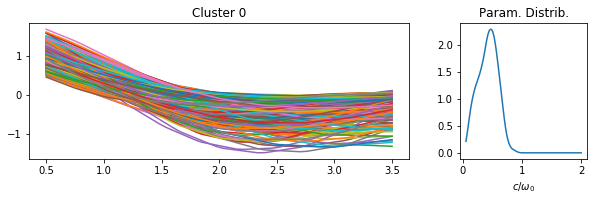

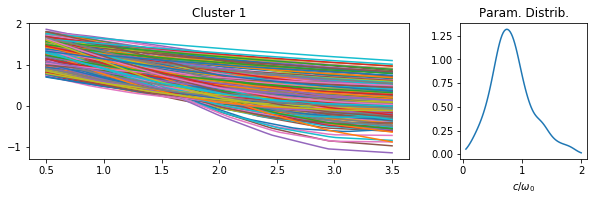

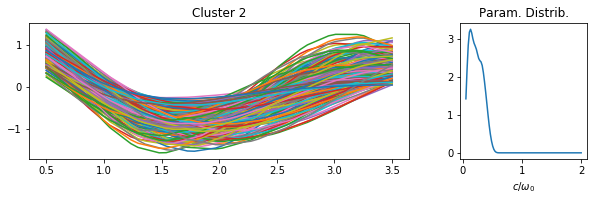

In [5]:
# Plot clusters of predicted time series
for j in range(learn.num_clusters):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2.5), gridspec_kw={'width_ratios': [3, 1]}) 
    ps = []
    for i in range(num_samples):
        if learn.predict_labels[i] == j:
            ps.append(params[i,0]/params[i,1])
            ax1.plot(learn.clean_times, learn.clean_predictions[i, :])
    ax1.set(title='Cluster ' + str(j))
    xs = np.linspace(0.05, 2.0, 100)
    ax2.plot(xs, GKDE(ps)(xs))
    ax2.set(xlabel=r'$c/\omega_0$', title='Param. Distrib.')
    

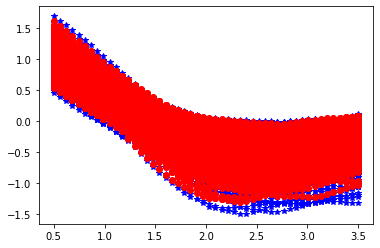

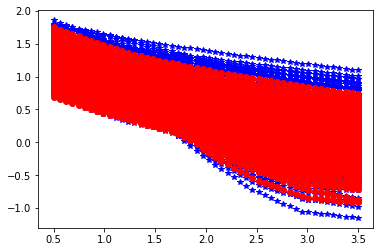

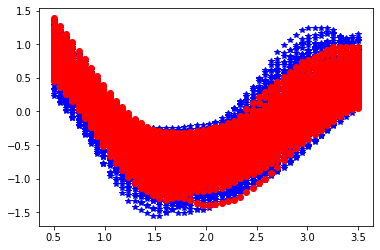

In [6]:
# Plot oberved and predicted clusters
for j in range(learn.num_clusters):
    plt.figure()
    cluster_num = j
    for i in range(num_samples):
        if learn.predict_labels[i] == cluster_num:
            plt.plot(learn.clean_times, learn.clean_predictions[i,:],'b*')
    for i in range(num_obs):
        if learn.obs_labels[i] == cluster_num:
            plt.plot(learn.clean_times, learn.clean_obs[i,:],'ro')

In [7]:
# Find best KPCA transformation for given number of QoI and transform time series data.
predict_map, obs_map = learn.learn_qois_and_transform(num_qoi=4)

4 principal components explain 99.9719% of variance for cluster 0 with {'kernel': 'linear'}
4 principal components explain 60.3079% of variance for cluster 0 with {'kernel': 'rbf'}
4 principal components explain 90.3446% of variance for cluster 0 with {'kernel': 'sigmoid'}
4 principal components explain 83.2915% of variance for cluster 0 with {'kernel': 'poly'}
4 principal components explain 99.9495% of variance for cluster 0 with {'kernel': 'cosine'}
Best kPCA for cluster  0  is  {'kernel': 'linear'}
4 principal components explain 99.9719% of variance.
4 principal components explain 99.9953% of variance for cluster 1 with {'kernel': 'linear'}
4 principal components explain 74.8303% of variance for cluster 1 with {'kernel': 'rbf'}
4 principal components explain 96.0531% of variance for cluster 1 with {'kernel': 'sigmoid'}
4 principal components explain 93.9153% of variance for cluster 1 with {'kernel': 'poly'}
4 principal components explain 99.9840% of variance for cluster 1 with {'ker

In [8]:
# Generate kernel density estimates on new QoI
learn.generate_kdes()
# Calculate rejection rates for each cluster and print averages.
r_vals = learn.compute_r()

Average rejection rates for clusters: [1.1926373100602339, 1.1539243784994295, 1.1936689095629127]


In [9]:
param_marginals = []
ic_marginals = []
true_param_marginals = []
true_ic_marginals = []
lam_ptr = []
cluster_weights = []
for i in range(learn.num_clusters):
    lam_ptr.append(np.where(learn.predict_labels == i)[0])
    cluster_weights.append(len(np.where(learn.obs_labels == i)[0]) / num_obs)

for i in range(params.shape[1]):
    true_param_marginals.append(GKDE(params_obs[:,i]))
    param_marginals.append([])
    for j in range(learn.num_clusters):
        param_marginals[i].append(GKDE(params[lam_ptr[j], i], weights=learn.r[j]))
        
for i in range(ics.shape[1]):
    true_ic_marginals.append(GKDE(ics_obs[:,i]))
    ic_marginals.append([])
    for j in range(learn.num_clusters):
        ic_marginals[i].append(GKDE(ics[lam_ptr[j], i], weights=learn.r[j]))

In [10]:
def unif_dist(x, p_range):
    y = np.zeros(x.shape)
    val = 1.0/(p_range[1] - p_range[0])
    for i, xi in enumerate(x):
        if xi < p_range[0] or xi >  p_range[1]:
            y[i] = 0
        else:
            y[i] = val
    return y

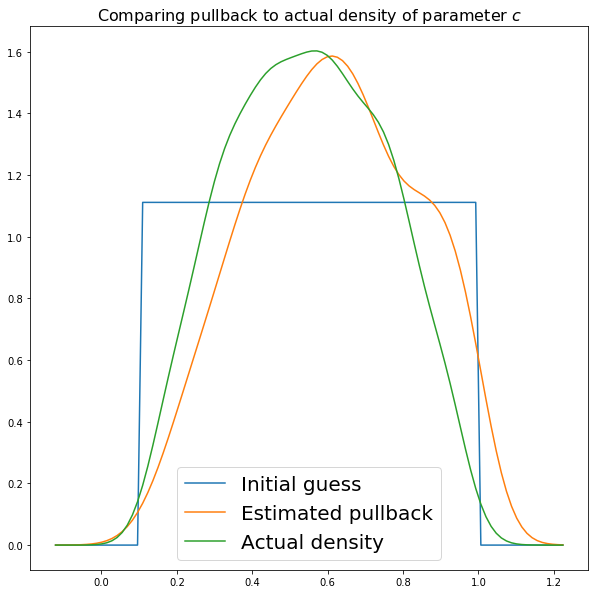

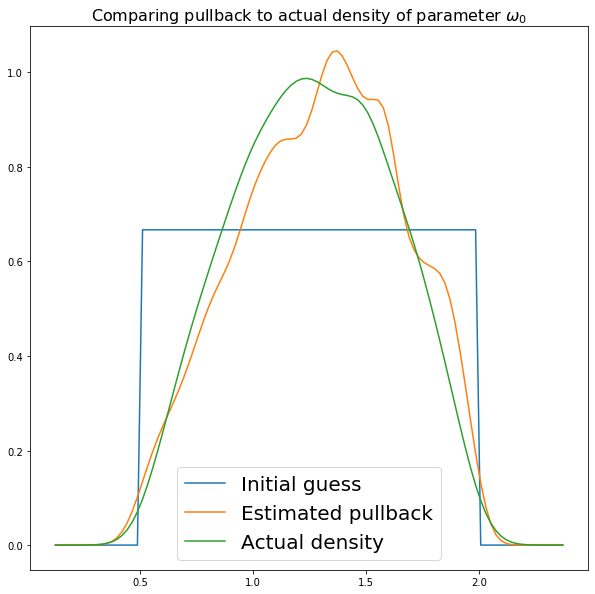

In [11]:
for i in range(params.shape[1]):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    x_min = min(min(params[:, i]), min(params_obs[:, i]))
    x_max = max(max(params[:, i]), max(params_obs[:, i]))
    delt = 0.25*(x_max - x_min)
    x = np.linspace(x_min-delt, x_max+delt, 100)
    plt.plot(x, unif_dist(x, param_range[i, :]),
         label = 'Initial guess')
    mar = np.zeros(x.shape)
    for j in range(learn.num_clusters):
        mar += param_marginals[i][j](x) * cluster_weights[j]
    plt.plot(x, mar, label = 'Estimated pullback')
    plt.plot(x, true_param_marginals[i](x), label = 'Actual density')
    plt.title('Comparing pullback to actual density of parameter ' + param_labels[i], fontsize=16)
    plt.legend(fontsize=20)

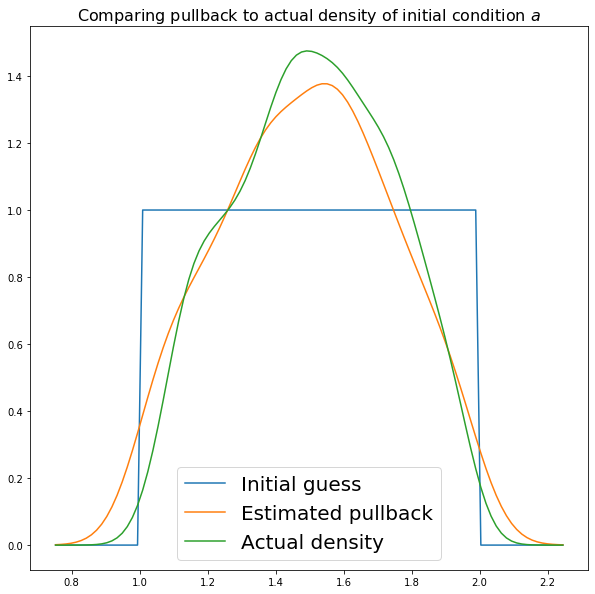

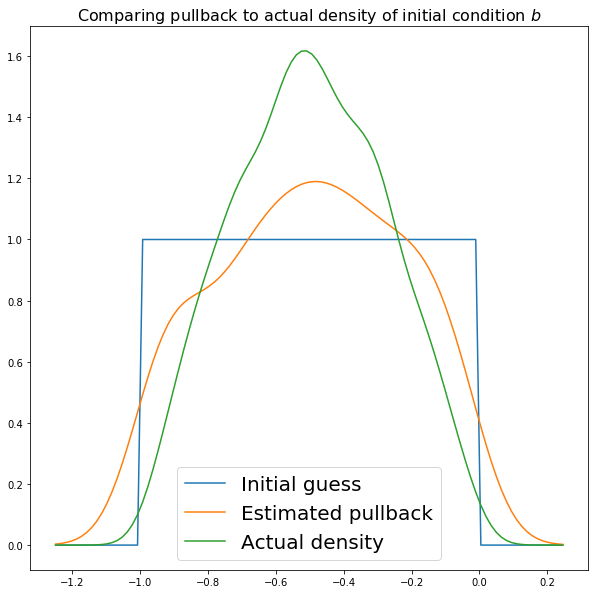

In [12]:
for i in range(ics.shape[1]):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    x_min = min(min(ics[:, i]), min(ics_obs[:, i]))
    x_max = max(max(ics[:, i]), max(ics_obs[:, i]))
    delt = 0.25*(x_max - x_min)
    x = np.linspace(x_min-delt, x_max+delt, 100)
    plt.plot(x, unif_dist(x, ic_range[i, :]),
         label = 'Initial guess')
    mar = np.zeros(x.shape)
    for j in range(learn.num_clusters):
        mar += ic_marginals[i][j](x) * cluster_weights[j]
    plt.plot(x, mar, label = 'Estimated pullback')
    plt.plot(x, true_ic_marginals[i](x), label = 'Actual density')
    plt.title('Comparing pullback to actual density of initial condition ' + ic_labels[i], fontsize=16)
    plt.legend(fontsize=20)